### Determinando un FVG
Lo primero que debemos hacer es leer data.
Vamos a descargar data de BTCUSDT en el rango 2023-08-09 - 2023-08-11 (9 al 11 de Agosto de 2023) en la temporalidad M5

In [29]:
import pandas as pd
from lightweight_charts import Chart
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np

Este es un zip que tiene los datos de un solo dia 11 de Agosto en M5

In [2]:
zipfile_name = 'BTCUSDT-5m-2023-03.zip'
file_name = zipfile_name.replace(".zip", ".csv")
data_path = os.path.join('btc_fvg', zipfile_name)
# btc_fvg\BTCUSDT-5m-2023-08-11.zip

Leer el dataframe

In [3]:
def read_csv(data_path, file_name):
    """
    Function to read csv inside zip.
    Input path strings
    Output: Pandas Dataframe
    """ 
    with zipfile.ZipFile(data_path, 'r') as zip_ref:
        with zip_ref.open(file_name) as csv_file:
            # Lee el archivo CSV utilizando Pandas
            dataframe = pd.read_csv(csv_file)
            return dataframe


In [4]:
data = read_csv(data_path, file_name)
#data.head()

Function to clean data to what i need


In [5]:

def prep_data(dataframe):
    # Eliminating irrelevant columns
    dataframe = dataframe[['open_time', 'open', 'high', 'low','close', 'volume']]
    dataframe['open_time'] = pd.to_datetime(dataframe['open_time'],unit='ms')
    return dataframe

In [6]:
data_cleaned = prep_data(data)

/var/folders/lw/mwc8q8hj6t9bsfnbts70kxth0000gn/T/ipykernel_5021/2521195782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['open_time'] = pd.to_datetime(dataframe['open_time'],unit='ms')


Rename dataframe to match lightweight charts module requirement


In [7]:
data_cleaned = data_cleaned.rename(columns={"open_time": "time"})

# Setear el index como el timestamp de la
data_cleaned.set_index('time', inplace=True)

#data_cleaned

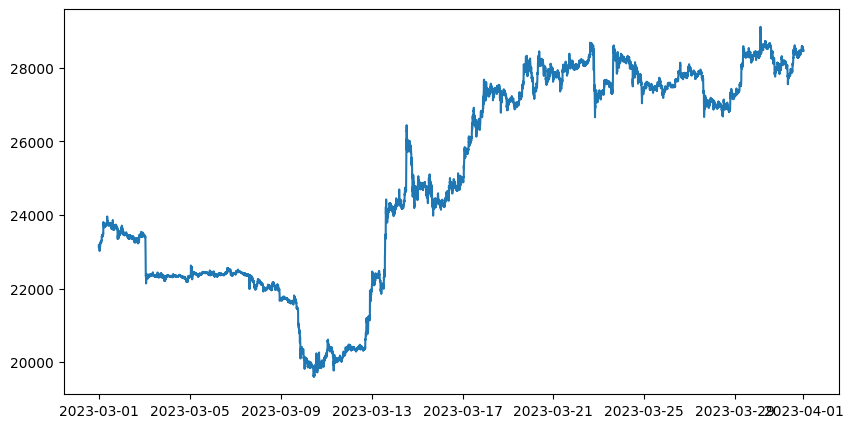

In [36]:
# Plot to get an idea of overall trend on the month
plt.figure(figsize=(10,5))
plt.plot(data_cleaned["close"])

### Optional Features
##### Resampling data to desired timeframe. 
Not used for this btc analysis.
In this example we wil resample to M15 candles.

In [9]:
data_resampled = data_cleaned.resample('15Min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last','volume':'sum'})

#data_resampled

##### Select date ranges from dataframe with timestamp index
Select an specific date range from the entire dataset, asumming the dataframe is clean and have *time,open,high,low,close,volume* columns

In [10]:
# Select test start and finish
start_date_1 = '2023-07-20 00:00:00'
finish_date_1 = '2023-07-24 23:55:00'

# Apply mask on function
def select_daterange(dataframe, start_date, finish_date):
    selected = dataframe.loc[start_date:finish_date]
    return selected

data_selected = select_daterange(data_cleaned,start_date_1,finish_date_1)
#data_selected


#### Casper Silver Bullet Strategy
- 10-11 am NY time (UCT-4) =  14-15 UTC time

In [11]:
# Prueba para saber como seleccionar solamente las candles que pertenezcan a ese rango horario.
df_silverbullet = data_selected.between_time('14:00:00', '15:00:00')
#df_silverbullet

Function to create our desired time ranges for start, which is 10am-11am NY time, traslated to UTC is 14:00-15:00.
It should iterate over all the days and select:
- Candles inside this timeframe.
- 1 candle prior to this timeframe, in order to be able to capture the first FVG.

In [12]:
# Cómo restar tiempo a un index timestamp en pandas.
#data_selected.index[1] - pd.Timedelta(minutes=10)

#### Function to Append to a dataframe (Deprecated)
Function to be able to append a row to a dataframe, since the original function is deprecated.


In [13]:
def custon_append(self, other, ignore_index=False, verify_integrity=False, sort=False):
    if ignore_index and not verify_integrity:
        sort = False
    return pd.concat(
        [self, other],
        ignore_index=ignore_index,
        verify_integrity=verify_integrity,
        sort=sort
    )
pd.DataFrame.append = custon_append

### FVG Logic
Inspired in: https://trendspider.com/blog/fair-value-gap-basics/ 

##### Bullish FVG
    Price.Low (last) is greater than Price.High (2 candles ago) – This defines the lack of overlap between candle wicks
    Price.Close (1 candle ago) is greater than Price.Open (1 candle ago) by at least ‘x %’ – This defines the large buying pressure
    Price.Close (1 candle ago) is greater than Price.High  (2 candles ago) – This defines that the candle with the buying pressure closed above the high of the previous candle

- Definimos un gap minimo, porcentual. GAP = %
- EL LOW de la vela actual (last) es *mayor* que el HIGH de la vela 2 posiciones anterior.
- El CLOSE de la vela anterior (1 posicion anterior) es *mayor* que el OPEN de la vela 1 posicion anterior por al menos el GAP porcentual.
- El CLOSE de la vela 1 posicion anterior es *mayor* que el HIGH de la vela 2 posisciones anterior.


##### Bearish FVG
    Price.High (last) is less than Price.Low (2 candles ago) – This defines the lack of overlap between candle wicks
    Price.Close (1 candle ago) is less than Price.Open (1 candle ago) by at least ‘x %’ – This defines the large selling pressure
    Price.Close (1 candle ago) is less than Price.Low (2 candles ago) – This defines that the candle with the selling pressure closed below the low of the previous candle

- Definimos un gap minimo, porcentual. GAP = %
- El HIGH de la vela actual (last) es *menor* que el LOW de la vela 2 posiciones anterior.
- El CLOSE de la vela 1 posicion anterior es *menor* que el OPEN de la vela 1 posicion anterior por al menos el GAP porcentual.
- El CLOSE de la vela 1 posicion anterior es *menor* que el LOW de la vela 2 posiciones anterior.

In [14]:
# funcion para determinar FVG. SE dejará para después.

def fvg_detector(dataframe):
    # Define porcentual GAP
    percentual_gap = 1.00003
    
    # Obtain daily_df lenght
    lenght = len(dataframe)
    
    # Entramos por cada fila
    for candle in range(lenght):
        #print(f"La vela {candle} tiene como open price {dataframe.iloc[candle]['open']}")
        # Define gap in USD:
        usd_gap = dataframe.iloc[candle-2]['high']*percentual_gap

        if candle >= 2:
            # Bulish FVG
            if dataframe.iloc[candle]['low'] > dataframe.iloc[candle-2]['high']\
            and dataframe.iloc[candle-1]['close'] > dataframe.iloc[candle-1]['open']\
            and dataframe.iloc[candle-1]['close'] > dataframe.iloc[candle-2]['high']:
            #and dataframe.iloc[candle]['close'] > dataframe.iloc[candle]['open']
                print(f"La vela {candle} generó un Bullish FVG en la vela {candle-1}, lowbarrier: {dataframe.iloc[candle-2]['high']}, high barrier: {dataframe.iloc[candle]['low']}")
            
            # Bearish FVG:
            if dataframe.iloc[candle]['high'] < dataframe.iloc[candle-2]['low']\
            and dataframe.iloc[candle-1]['close'] < dataframe.iloc[candle-1]['open']\
            and dataframe.iloc[candle-1]['close'] < dataframe.iloc[candle-2]['low']:
            #and dataframe.iloc[candle]['close'] < dataframe.iloc[candle]['open']
                print(f"La vela {candle} generó un Bearish FVG en la vela {candle-1}, lowbarrier: {dataframe.iloc[candle]['high']}, high barrier: {dataframe.iloc[candle-2]['low']}")

    return

#fvg_detector(data_cleaned)

### Casper Silver Bullet Strategy:
Rules:
- Entry on first FVG created between 14:00 and 15:00 UTC (NY 10:00-11:00 am session) only weekdays.
- 2R fixed Risk to reward
- Close position at TP or at 20:00 UTC (NY 16:00)
- If price reach TP before entry, cancel order.
- FVG can be formed using previous candle as first of the three candles forming FVG.

In [15]:
# Original function created by me to detect ALL FVG
def casper_fvg(dataframe):
        
    #Silve Bullet parameters:
    sb_start = pd.Timestamp("14:00:00").time()
    sb_end = pd.Timestamp("15:00:00").time()
    executed_today = False

    for time, candle in dataframe.iterrows():
               
        position_open = False

        # Condition to iterate only on weekdays between 14-15 UTC:
        if sb_start <= time.time() <= sb_end and time.weekday()<5:

            # Bullish FVG
            if dataframe['low'].loc[time] > dataframe['high'].shift(2).loc[time]\
            and dataframe['close'].shift(1).loc[time] > dataframe['open'].shift(1).loc[time]\
            and dataframe['close'].shift(1).loc[time] > dataframe['high'].shift(2).loc[time]:
                print(f"La vela {time} generó un Bullish FVG ,lowbarrier: {dataframe['high'].shift(2).loc[time]}, high barrier: {dataframe['low'].loc[time]}")
                executed_today = True
                

            # Bearish FVG:
            if dataframe['high'].loc[time] < dataframe['low'].shift(2).loc[time]\
            and dataframe['close'].shift(1).loc[time] < dataframe['open'].shift(1).loc[time]\
            and dataframe['close'].shift(1).loc[time] < dataframe['low'].shift(2).loc[time]: 
                print(f"La vela {time} generó un Bearish FVG, lowbarrier: {dataframe['high'].loc[time]}, high barrier: {dataframe['low'].shift(2).loc[time]}")
                executed_today = True
                
        
#casper_fvg(data_cleaned)

##### Funcion para detectar si el precio tocó el nivel:

Caso BULLISH (Se tiene entry, sl y tp), se entiende que el precio está por encima de la entrada
La vela que genera el FVG y la señal de entrada es (candle+0)
- Si el LOW de la vela siguiente (candle+1) y de las subsiguientes <= que entry >> ENTRY FILLED
- Si el HIGH de esa misma vela (candle+1) y de las subsiguientes <= que SL >> SL TAKEN OUT
- Si el LOW de esa misma vela (candle+1) y de las subsiguientes >= que el TP >> TP Reached


Caso SHORT (Se tiene entry, sl y tp), se entiende que el precio está por debajo de la entrada
La vela que genera el FVG y la señal de entrada es (candle+0)
- Si el HIGH de la vela siguiente (candle+1) y de las subsiguientes  >= que entry >> ENTRY FILLED
- Si el HIGH de esa misma vela (candle+1) y de las subsiguientes >= que SL >> SL TAKEN OUT
- Si el LOW de esa misma vela (candle+1) y de las subsiguientes <= que el TP >> TP Reached


In [16]:
def backtest(entries_df, daily_df, time, side, entry, sl, tp, size):
    """
    Receives:
    daily_df: Daily Pandas dataframe where tha signal was detected.
    time: Time the signal is received, also time where the order should be placed.
    side: LONG, SHORT
    entry: Price the order is placed .
    sl: stoploss price associated to the order.
    tp: takeprofit associated to the order.
    size: Order size.
    """
    temp_df = entries_df

    # Tengo hacer que esta funcion coja el daily_df y recorra fila a fila para saber si es que se ejecuta o no. Ahorita solo detecta si se entró 
    signal_timestamp = time.time() #Pandas timestamp entry signal. Se debe iterar a partir del siguiente.
    session_end = pd.Timestamp("18:00:00").time()

    # Iterate over daily_df received
    for time2, candle2 in daily_df.iterrows():
    
        # Next candle
        #next_candle = time2
        next_candle = time2+pd.Timedelta(minutes=5)
        next_candle2 = next_candle+pd.Timedelta(minutes=5)

        # Condition to iterate only after signal is received
        if signal_timestamp <= time2.time() <= session_end:
            
            # BULLISH CASE
            if side == 'buy':
                # Entry check: Si el LOW de la vela siguiente (candle+1) y de las subsiguientes <= que entry >> ENTRY FILLED
                if daily_df['low'].loc[next_candle] <= entry:
                    
                    print(f"La señal de LONG fue ejecutada en {next_candle}")  # hasta aca esta bien,ya tengo posicion

                    for time3, candle3 in daily_df.iterrows():
                        if  next_candle2.time() <= time3.time() <= session_end:

                            # CHECK TRADE RESULT         
                            # Si el LOW de esa misma vela (candle+1) y de las subsiguientes >= que el TP >> TP Reached   
                            if daily_df['high'].loc[time3] >= tp:
                                print(f"El precio alcanzó el TAKE PROFIT en {time3}")
                                new_row = {'side': "LONG", 'filled':time3, 'result': "W",'profit':2}
                                temp_df.loc[len(entries_df)] = new_row
                                break
                            

                            # Si el HIGH de esa misma vela (candle+1) y de las subsiguientes <= que SL >> SL TAKEN OUT 
                            elif daily_df['low'].loc[time3] <= sl:
                                print(f"El precio alcanzó el STOP LOSS en {time3}")
                                new_row = {'side': "LONG", 'filled':time3, 'result': "L",'profit':-1}
                                temp_df.loc[len(entries_df)] = new_row
                                break
                            # Si se acaba la sesión. NO DETECTA
                            elif time3 == session_end:
                                print(f"Se corta el trade en {time3}")
                                new_row = {'side': "LONG", 'filled':time3, 'result': "P",'profit':0}
                                temp_df.loc[len(entries_df)] = new_row
                                break
                    break
                
            # BEARISH CASE
            elif side == 'sell':
                # Entry check: Si el HIGH de la vela siguiente (candle+1) y de las subsiguientes  >= que entry >> ENTRY FILLED
                if daily_df['high'].loc[next_candle] >= entry:
                    print(f"La señal de SHORT fue ejecutada en {next_candle}")

                    for time3, candle3 in daily_df.iterrows():
                        if  next_candle2.time() <= time3.time() <= session_end:

                            # CHECK TRADE RESULT                            
                            # Si el HIGH de esa misma vela (candle+1) y de las subsiguientes >= que SL >> SL TAKEN OUT
                            if daily_df['high'].loc[time3] >= sl:
                                print(f"El precio alcanzó el STOP LOSS en {time3}")
                                new_row = {'side': "SHORT", 'filled':time3, 'result': "L",'profit':-1}
                                temp_df.loc[len(entries_df)] = new_row
                                break
                                    
                            # Si el LOW de esa misma vela (candle+1) y de las subsiguientes <= que el TP >> TP Reached
                            elif daily_df['low'].loc[time3] <= tp:
                                print(f"El precio alcanzó el TAKE PROFIT en {time3}")
                                new_row = {'side': "SHORT", 'filled':time3, 'result': "W",'profit':2}
                                temp_df.loc[len(entries_df)] = new_row
                                break
                            # Si se acaba la sesión
                            elif time3 == session_end:
                                print(f"Se corta el trade en {time3}")
                                new_row = {'side': "SHORT", 'filled':time3, 'result': "P",'profit':0}
                                temp_df.loc[len(entries_df)] = new_row
                                break
                    break

    return entries_df

In [17]:
# Function to set limit orders on Mt5 or TV/Binance
def enter_position(side, price, sl):

    # Define TP:
    tp_long = round(price + (price-sl)*2, 2)
    tp_short = round(price - (sl-price)*2, 2)
    size = 1

    if side == "buy":
        print(f"Se abre una position LONG, entrada: {price}, sl: {sl}, tp: {tp_long}, vol: {size} ")
    if side == "sell":
        print(f"Se abre una position SHORT, entrada: {price}, sl: {sl}, tp: {tp_short}, vol: {size} ")
    return tp_long, tp_short,size
    

In [18]:
# Function to detect strategy on given parameters
def casper_fvg(dataframe):
    entries_df = pd.DataFrame(columns=['time','side', 'filled','result', 'profit'])
    #entries_df = entries_df.set_index('time')
    
    # Silver Bullet session parameters:
    sb_start = pd.Timestamp("14:05:00").time() #Se empieza enla vela siguiente para no detectar el FVG previo.
    sb_end = pd.Timestamp("15:00:00").time()

    # Firs loop to create "groups" as a dataframe for every single day.
    for date, group in dataframe.groupby(dataframe.index.date):
        executed_today = False

        # Second loop to iterate over all candles on each single day
        for time, candle in group.iterrows():

            #Timestamp for next candle from the iteration
            #next_candle = time

            # Check if already detected today
            if executed_today:
                break

            # Condition to iterate only on weekdays between 14-15 UTC
            if sb_start <= time.time() <= sb_end and time.weekday() < 5:
                
                # Bullish FVG
                if group['low'].loc[time] > group['high'].shift(2).loc[time]\
                and group['close'].shift(1).loc[time] > group['high'].shift(2).loc[time]:
                #and group['close'].shift(1).loc[time] > group['open'].shift(1).loc[time]
                    lowbarrier = group['high'].shift(2).loc[time]
                    highbarrier = group['low'].loc[time]
                    entry = group['low'].loc[time]
                    stoploss = group['low'].shift(2).loc[time]

                    
                    print(f"La vela {time} generó un Bullish FVG, lowbarrier: {lowbarrier}, high barrier: {highbarrier}")
                    executed_today = True
                    position = enter_position(side='buy', price=entry, sl=stoploss) #return tplong, tpshort, size
                              
                    backtest(entries_df=entries_df, daily_df=group, time=time, side='buy', entry=entry, sl=stoploss,tp=position[0], size=1)
                    
                    print("-----------------------------------------------------------")


                # Bearish FVG
                elif group['high'].loc[time] < group['low'].shift(2).loc[time]\
                and group['close'].shift(1).loc[time] < group['low'].shift(2).loc[time]:
                #and group['close'].shift(1).loc[time] < group['open'].shift(1).loc[time]
                    lowbarrier = group['high'].loc[time]
                    highbarrier = group['low'].shift(2).loc[time]
                    entry = group['high'].loc[time]
                    stoploss = group['high'].shift(2).loc[time]

                    print(f"La vela {time} generó un Bearish FVG, lowbarrier: {lowbarrier}, high barrier: {lowbarrier}")
                    executed_today = True
                    position = enter_position(side="sell", price=entry, sl=stoploss)
                    backtest(entries_df=entries_df, daily_df=group, time=time, side='sell', entry=entry, sl=stoploss,tp=position[1], size=1)
                    
                    print("-----------------------------------------------------------")

    return entries_df
zz = casper_fvg(data_cleaned)

La vela 2023-03-01 14:45:00 generó un Bullish FVG, lowbarrier: 23672.7, high barrier: 23708.1
Se abre una position LONG, entrada: 23708.1, sl: 23558.0, tp: 24008.3, vol: 1 
La señal de LONG fue ejecutada en 2023-03-01 14:55:00
El precio alcanzó el STOP LOSS en 2023-03-01 16:10:00
-----------------------------------------------------------
La vela 2023-03-02 14:10:00 generó un Bearish FVG, lowbarrier: 23266.0, high barrier: 23266.0
Se abre una position SHORT, entrada: 23266.0, sl: 23337.7, tp: 23122.6, vol: 1 
La señal de SHORT fue ejecutada en 2023-03-02 14:15:00
El precio alcanzó el STOP LOSS en 2023-03-02 15:00:00
-----------------------------------------------------------
La vela 2023-03-07 14:30:00 generó un Bearish FVG, lowbarrier: 22328.0, high barrier: 22328.0
Se abre una position SHORT, entrada: 22328.0, sl: 22355.1, tp: 22273.8, vol: 1 
La señal de SHORT fue ejecutada en 2023-03-07 14:35:00
El precio alcanzó el TAKE PROFIT en 2023-03-07 15:00:00
-------------------------------

In [19]:
zz

,time,side,filled,result,profit
0,NaN,LONG,2023-03-01 16:10:00,L,-1
1,NaN,SHORT,2023-03-02 15:00:00,L,-1
2,NaN,SHORT,2023-03-07 15:00:00,W,2
3,NaN,LONG,2023-03-09 15:15:00,L,-1
4,NaN,SHORT,2023-03-10 16:30:00,L,-1
5,NaN,LONG,2023-03-14 15:25:00,L,-1
6,NaN,SHORT,2023-03-15 14:55:00,L,-1
7,NaN,SHORT,2023-03-16 14:30:00,L,-1
8,NaN,LONG,2023-03-17 14:25:00,L,-1
9,NaN,LONG,2023-03-20 15:55:00,L,-1


In [20]:
total_profit = zz['profit'].sum()
print(f"Profit acumulado: {total_profit}")

Profit acumulado: -6


podemos probar con varias combinaciones de rangos horarios en este caso para BTC

##### Iterate over all zip files to analyze data

In [21]:
import os

# Ruta de la carpeta
folder = 'btc_fvg'

# Obtener todos los nombres de archivos en la carpeta
filenames = os.listdir(folder)
filenames


['BTCUSDT-5m-2023-06.zip',
 'BTCUSDT-5m-2023-07.zip',
 'BTCUSDT-5m-2023-05.zip',
 'BTCUSDT-5m-2023-04.zip',
 'BTCUSDT-5m-2023-01.zip',
 'BTCUSDT-5m-2023-03.zip',
 'BTCUSDT-5m-2023-02.zip']

In [22]:
# Apply function to backtest data for every month:

def backtest_pipeline (folder, filenames):

    master_df = pd.DataFrame(columns=['time','side', 'filled','result', 'profit'])
    
    for file in filenames:
        csv_filename = file.replace(".zip", ".csv")
        data_path = os.path.join(folder, file)
        #print (data_path)
        #print(csv_filename)
        data = read_csv(data_path=data_path, file_name=csv_filename)
        data_cleaned = prep_data(data)
        data_cleaned = data_cleaned.rename(columns={"open_time": "time"})
        data_cleaned.set_index('time', inplace=True)

        # Apply casper_fvg function
        zz = casper_fvg(data_cleaned)
        master_df = pd.concat([master_df, zz])
    return master_df

         

kk = backtest_pipeline(folder='btc_fvg', filenames=filenames)


La vela 2023-06-01 14:20:00 generó un Bearish FVG, lowbarrier: 26866.8, high barrier: 26866.8
Se abre una position SHORT, entrada: 26866.8, sl: 26944.0, tp: 26712.4, vol: 1 
La señal de SHORT fue ejecutada en 2023-06-01 14:25:00
El precio alcanzó el STOP LOSS en 2023-06-01 16:50:00
-----------------------------------------------------------
La vela 2023-06-02 14:25:00 generó un Bearish FVG, lowbarrier: 26926.7, high barrier: 26926.7
Se abre una position SHORT, entrada: 26926.7, sl: 26956.0, tp: 26868.1, vol: 1 
La señal de SHORT fue ejecutada en 2023-06-02 14:30:00
El precio alcanzó el STOP LOSS en 2023-06-02 14:40:00
-----------------------------------------------------------
La vela 2023-06-05 14:05:00 generó un Bullish FVG, lowbarrier: 26736.0, high barrier: 26742.5
Se abre una position LONG, entrada: 26742.5, sl: 26713.1, tp: 26801.3, vol: 1 
La señal de LONG fue ejecutada en 2023-06-05 14:10:00
El precio alcanzó el STOP LOSS en 2023-06-05 14:15:00
---------------------------------

/var/folders/lw/mwc8q8hj6t9bsfnbts70kxth0000gn/T/ipykernel_5021/2521195782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['open_time'] = pd.to_datetime(dataframe['open_time'],unit='ms')
/var/folders/lw/mwc8q8hj6t9bsfnbts70kxth0000gn/T/ipykernel_5021/2197212640.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_df = pd.concat([master_df, zz])


La vela 2023-07-03 14:05:00 generó un Bullish FVG, lowbarrier: 30647.5, high barrier: 30664.5
Se abre una position LONG, entrada: 30664.5, sl: 30608.4, tp: 30776.7, vol: 1 
La señal de LONG fue ejecutada en 2023-07-03 14:10:00
El precio alcanzó el TAKE PROFIT en 2023-07-03 15:00:00
-----------------------------------------------------------
La vela 2023-07-04 14:45:00 generó un Bearish FVG, lowbarrier: 30994.3, high barrier: 30994.3
Se abre una position SHORT, entrada: 30994.3, sl: 31036.1, tp: 30910.7, vol: 1 
La señal de SHORT fue ejecutada en 2023-07-04 14:50:00
El precio alcanzó el TAKE PROFIT en 2023-07-04 15:25:00
-----------------------------------------------------------
La vela 2023-07-05 14:20:00 generó un Bullish FVG, lowbarrier: 30365.3, high barrier: 30369.2
Se abre una position LONG, entrada: 30369.2, sl: 30316.6, tp: 30474.4, vol: 1 
La señal de LONG fue ejecutada en 2023-07-05 15:00:00
El precio alcanzó el STOP LOSS en 2023-07-05 15:15:00
-------------------------------

/var/folders/lw/mwc8q8hj6t9bsfnbts70kxth0000gn/T/ipykernel_5021/2521195782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['open_time'] = pd.to_datetime(dataframe['open_time'],unit='ms')


-----------------------------------------------------------
La vela 2023-07-11 14:25:00 generó un Bullish FVG, lowbarrier: 30404.1, high barrier: 30437.8
Se abre una position LONG, entrada: 30437.8, sl: 30360.1, tp: 30593.2, vol: 1 
-----------------------------------------------------------
La vela 2023-07-12 14:05:00 generó un Bullish FVG, lowbarrier: 30673.5, high barrier: 30740.0
Se abre una position LONG, entrada: 30740.0, sl: 30589.4, tp: 31041.2, vol: 1 
La señal de LONG fue ejecutada en 2023-07-12 14:10:00
El precio alcanzó el STOP LOSS en 2023-07-12 15:35:00
-----------------------------------------------------------
La vela 2023-07-13 14:05:00 generó un Bearish FVG, lowbarrier: 30570.0, high barrier: 30570.0
Se abre una position SHORT, entrada: 30570.0, sl: 30650.0, tp: 30410.0, vol: 1 
La señal de SHORT fue ejecutada en 2023-07-13 14:30:00
El precio alcanzó el STOP LOSS en 2023-07-13 15:25:00
-----------------------------------------------------------
La vela 2023-07-14 14:0

/var/folders/lw/mwc8q8hj6t9bsfnbts70kxth0000gn/T/ipykernel_5021/2521195782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['open_time'] = pd.to_datetime(dataframe['open_time'],unit='ms')
/var/folders/lw/mwc8q8hj6t9bsfnbts70kxth0000gn/T/ipykernel_5021/2521195782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['open_time'] = pd.to_datetime(dataframe['open_time'],unit='ms')
/var/folders/lw/mwc8q8hj6t9bsfnbts70kxth0000gn/T/ipykernel_5021/2521195782.py:4: SettingWithCopyWarning: 
A va

La vela 2023-04-03 14:35:00 generó un Bearish FVG, lowbarrier: 28185.8, high barrier: 28185.8
Se abre una position SHORT, entrada: 28185.8, sl: 28230.0, tp: 28097.4, vol: 1 
-----------------------------------------------------------
La vela 2023-04-04 14:35:00 generó un Bullish FVG, lowbarrier: 28156.5, high barrier: 28190.0
Se abre una position LONG, entrada: 28190.0, sl: 28094.2, tp: 28381.6, vol: 1 
La señal de LONG fue ejecutada en 2023-04-04 14:40:00
El precio alcanzó el STOP LOSS en 2023-04-04 14:55:00
-----------------------------------------------------------
La vela 2023-04-05 14:05:00 generó un Bearish FVG, lowbarrier: 28290.6, high barrier: 28290.6
Se abre una position SHORT, entrada: 28290.6, sl: 28397.3, tp: 28077.2, vol: 1 
-----------------------------------------------------------
La vela 2023-04-07 14:55:00 generó un Bearish FVG, lowbarrier: 27913.7, high barrier: 27913.7
Se abre una position SHORT, entrada: 27913.7, sl: 27942.9, tp: 27855.3, vol: 1 
La señal de SHORT

/var/folders/lw/mwc8q8hj6t9bsfnbts70kxth0000gn/T/ipykernel_5021/2521195782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['open_time'] = pd.to_datetime(dataframe['open_time'],unit='ms')
/var/folders/lw/mwc8q8hj6t9bsfnbts70kxth0000gn/T/ipykernel_5021/2521195782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['open_time'] = pd.to_datetime(dataframe['open_time'],unit='ms')


La vela 2023-03-01 14:45:00 generó un Bullish FVG, lowbarrier: 23672.7, high barrier: 23708.1
Se abre una position LONG, entrada: 23708.1, sl: 23558.0, tp: 24008.3, vol: 1 
La señal de LONG fue ejecutada en 2023-03-01 14:55:00
El precio alcanzó el STOP LOSS en 2023-03-01 16:10:00
-----------------------------------------------------------
La vela 2023-03-02 14:10:00 generó un Bearish FVG, lowbarrier: 23266.0, high barrier: 23266.0
Se abre una position SHORT, entrada: 23266.0, sl: 23337.7, tp: 23122.6, vol: 1 
La señal de SHORT fue ejecutada en 2023-03-02 14:15:00
El precio alcanzó el STOP LOSS en 2023-03-02 15:00:00
-----------------------------------------------------------
La vela 2023-03-07 14:30:00 generó un Bearish FVG, lowbarrier: 22328.0, high barrier: 22328.0
Se abre una position SHORT, entrada: 22328.0, sl: 22355.1, tp: 22273.8, vol: 1 
La señal de SHORT fue ejecutada en 2023-03-07 14:35:00
El precio alcanzó el TAKE PROFIT en 2023-03-07 15:00:00
-------------------------------

In [23]:
kk

,time,side,filled,result,profit
0,NaN,SHORT,2023-06-01 16:50:00,L,-1
1,NaN,SHORT,2023-06-02 14:40:00,L,-1
2,NaN,LONG,2023-06-05 14:15:00,L,-1
3,NaN,LONG,2023-06-06 16:50:00,W,2
4,NaN,LONG,2023-06-09 14:35:00,L,-1
...,...,...,...,...,...
10,NaN,LONG,2023-02-21 14:30:00,W,2
11,NaN,SHORT,2023-02-22 14:55:00,W,2
12,NaN,LONG,2023-02-23 14:35:00,L,-1
13,NaN,LONG,2023-02-24 14:55:00,W,2


In [24]:
total_profit = kk['profit'].sum()
print(f"Profit acumulado: {total_profit}")

Profit acumulado: -5


##### Download massive data using binance API

In [25]:
import os
from binance.client import Client

# Credenciales de la API de Binance
api_key = 'TU_API_KEY'
api_secret = 'TU_API_SECRET'

# Crear una instancia del cliente de Binance
client = Client(api_key, api_secret)

# Carpeta para guardar los archivos descargados
carpeta = 'btc_fvg'
os.makedirs(carpeta, exist_ok=True)

# Obtener la lista de archivos disponibles para descargar
archivos_disponibles = client.futures_exchange_info()['symbols']

# Filtrar los archivos para obtener solo los de BTCUSDT-M
archivos_btc = [archivo['symbol'] for archivo in archivos_disponibles if archivo['symbol'].endswith('BTCUSDT-M')]

# Descargar los datos de cada archivo
for archivo in archivos_btc:
    nombre_archivo = f"{carpeta}/{archivo}-5m.zip"
    client.futures_klines(symbol=archivo, interval=Client.KLINE_INTERVAL_5MINUTE, save=True, path=nombre_archivo, limit=1000)
    print(f"Archivo {nombre_archivo} descargado exitosamente.")

/Users/egrados/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [26]:
este podria ser un verdadera problema
porque no se tiene el mismonivel de entusiasmo sobre la vidauniversitaria que se tiene sobre la vida de academia en el ecosistema apple


:::;;;;"""""""''''custon_append


"""




SyntaxError: invalid syntax (1300350593.py, line 1)

In [ ]:
dfsdf

In [35]:
print("soy gay")

soy gay


In [31]:
#Esto no odríasdasda